
# Sports filed registration

In [1]:
import os

import numpy as np
import torch
import imageio
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from tqdm import tqdm_notebook as tqdm

from sportsfield_release.utils import utils, warp, image_utils, constant_var
from sportsfield_release.models import end_2_end_optimization
from sportsfield_release.options import fake_options
import cv2

In [2]:
# if want to run on CPU, please make it False
constant_var.USE_CUDA = True
utils.fix_randomness()

# if GPU is RTX 20XX, please disable cudnn
torch.backends.cudnn.enabled = True

In [3]:
# set some options
opt = fake_options.FakeOptions()
opt.batch_size = 1
opt.coord_conv_template = True
opt.error_model = 'loss_surface'
opt.error_target = 'iou_whole'
# opt.goal_image_path = '../../VisionScore/clips/frame0.jpg'
opt.guess_model = 'init_guess'
opt.homo_param_method = 'deep_homography'
opt.load_weights_error_model = 'pretrained_loss_surface'
opt.load_weights_upstream = 'pretrained_init_guess'
opt.lr_optim = 1e-5
opt.need_single_image_normalization = True
opt.need_spectral_norm_error_model = True
opt.need_spectral_norm_upstream = False
opt.optim_criterion = 'l1loss'
opt.optim_iters = 200
opt.optim_method = 'stn'
opt.optim_type = 'adam'
opt.out_dir = './sportsfield_release/out'
opt.prevent_neg = 'sigmoid'
opt.template_path = '../data/template.png'
opt.warp_dim = 8
opt.warp_type = 'homography'

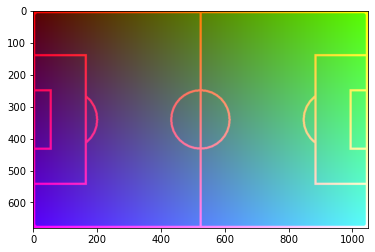

mean of template: 2.963424883262178e-08
std of template: 0.999999463558197


In [4]:
# read template image
template_image = imageio.imread(opt.template_path, pilmode='RGB')
template_image = template_image / 255.0
if opt.coord_conv_template:
    template_image = image_utils.rgb_template_to_coord_conv_template(template_image)
plt.imshow(template_image)
plt.show()
# covert np image to torch image, and do normalization
template_image = utils.np_img_to_torch_img(template_image)
if opt.need_single_image_normalization:
    template_image = image_utils.normalize_single_image(template_image)
print('mean of template: {0}'.format(template_image.mean()))
print('std of template: {0}'.format(template_image.std()))

In [5]:
e2e = end_2_end_optimization.End2EndOptimFactory.get_end_2_end_optimization_model(opt)

---------------------- NOTIFICATION ----------------------

Resnet backbone config for loss_surface
Spectral norm for resnet: True
Using BN for resnet
Imagenet pretrain weights for resnet: False

-------------------------- END --------------------------
---------------------- NOTIFICATION ----------------------

Weights loaded for loss_surface
From: ./sportsfield_release/out/pretrained_loss_surface/checkpoint.pth.tar

-------------------------- END --------------------------
---------------------- NOTIFICATION ----------------------

Resnet backbone config for init_guess
Spectral norm for resnet: False
Using BN for resnet
Imagenet pretrain weights for resnet: False

-------------------------- END --------------------------
---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: ./sportsfield_release/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


### Apply to video

In [7]:
opt.optim_iters = 80

In [6]:
video_cap = cv2.VideoCapture('../clips/contr.mp4')
frame_list = []
while True:
    success, image = video_cap.read()
    if not success:
        break
    pil_image = Image.fromarray(np.uint8(image[..., ::-1]))
    pil_image = pil_image.resize([1280, 720], resample=Image.NEAREST)
    image = np.array(pil_image)
    frame_list.append(image)

In [8]:
first_frame = True
optim_homography_list = []
for idx, frame in enumerate(frame_list):
        print('{0} / {1}'.format(idx+1, len(frame_list)))
        pil_image = Image.fromarray(np.uint8(frame))
        pil_image = pil_image.resize([256, 256], resample=Image.NEAREST)
        frame = np.array(pil_image)
        frame = utils.np_img_to_torch_img(frame)
        if opt.need_single_image_normalization:
            frame = image_utils.normalize_single_image(frame)
        _, optim_homography = e2e.optim(frame[None], template_image, refresh=first_frame)
        optim_homography_list.append(optim_homography.detach())
        first_frame = False

1 / 575
---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: ./sportsfield_release/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  1%|▏         | 1/80 [00:00<00:08,  9.41it/s]

2 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.46it/s]

3 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.52it/s]

4 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.35it/s]

5 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.41it/s]

6 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.39it/s]

7 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.29it/s]

8 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.40it/s]

9 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.36it/s]

10 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.47it/s]

11 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.47it/s]

12 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.48it/s]

13 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.42it/s]

14 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.47it/s]

15 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.47it/s]

16 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.34it/s]

17 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.37it/s]

18 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.40it/s]

19 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.45it/s]

20 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.38it/s]

21 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.41it/s]

22 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.37it/s]

23 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.53it/s]

24 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.39it/s]

25 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.44it/s]

26 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.38it/s]

27 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.43it/s]

28 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.35it/s]

29 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.35it/s]

30 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.30it/s]

31 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.48it/s]

32 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.30it/s]

33 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.28it/s]

34 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.48it/s]

35 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.44it/s]

36 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.39it/s]

37 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.22it/s]

38 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.32it/s]

39 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.38it/s]

40 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.47it/s]

41 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.51it/s]

42 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.31it/s]

43 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.50it/s]

44 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.44it/s]

45 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.28it/s]

46 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.48it/s]

47 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.48it/s]

48 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.42it/s]

49 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.43it/s]

50 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.43it/s]

51 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.48it/s]

52 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.46it/s]

53 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.47it/s]

54 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.54it/s]

55 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.48it/s]

56 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.40it/s]

57 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.40it/s]

58 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.44it/s]

59 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.53it/s]

60 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.38it/s]

61 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.44it/s]

62 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.46it/s]

63 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.44it/s]

64 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.45it/s]

65 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.47it/s]

66 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.47it/s]

67 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.54it/s]

68 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.48it/s]

69 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.43it/s]

70 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.47it/s]

71 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.51it/s]

72 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.40it/s]

73 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.38it/s]

74 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.46it/s]

75 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.49it/s]

76 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.47it/s]

77 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.25it/s]

78 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.45it/s]

79 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.32it/s]

80 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.47it/s]

81 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.42it/s]

82 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.45it/s]

83 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.50it/s]

84 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.34it/s]

85 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.43it/s]

86 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.50it/s]

87 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.36it/s]

88 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.52it/s]

89 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.34it/s]

90 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.28it/s]

91 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.51it/s]

92 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.40it/s]

93 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.42it/s]

94 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.30it/s]

95 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.46it/s]

96 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.47it/s]

97 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.38it/s]

98 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.38it/s]

99 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.49it/s]

100 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.47it/s]

101 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.42it/s]

102 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.48it/s]

103 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.45it/s]

104 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.45it/s]

105 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.47it/s]

106 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.45it/s]

107 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.51it/s]

108 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.37it/s]

109 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.40it/s]

110 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.50it/s]

111 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.39it/s]

112 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.43it/s]

113 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.50it/s]

114 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.47it/s]

115 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.45it/s]

116 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.41it/s]

117 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.31it/s]

118 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.34it/s]

119 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.33it/s]

120 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.45it/s]

121 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.27it/s]

122 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.41it/s]

123 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.54it/s]

124 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.35it/s]

125 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.35it/s]

126 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.52it/s]

127 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.47it/s]

128 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.39it/s]

129 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.42it/s]

130 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.42it/s]

131 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.45it/s]

132 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.50it/s]

133 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.39it/s]

134 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.37it/s]

135 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.48it/s]

136 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.38it/s]

137 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.46it/s]

138 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.35it/s]

139 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.46it/s]

140 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.44it/s]

141 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.29it/s]

142 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.40it/s]

143 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.51it/s]

144 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.36it/s]

145 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.45it/s]

146 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.47it/s]

147 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.35it/s]

148 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.51it/s]

149 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.37it/s]

150 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.48it/s]

151 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.27it/s]

152 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.50it/s]

153 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.44it/s]

154 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.43it/s]

155 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.46it/s]

156 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.43it/s]

157 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.18it/s]

158 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.31it/s]

159 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.31it/s]

160 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.45it/s]

161 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.47it/s]

162 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.47it/s]

163 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.33it/s]

164 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.43it/s]

165 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.43it/s]

166 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.48it/s]

167 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.50it/s]

168 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.27it/s]

169 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.43it/s]

170 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.45it/s]

171 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.34it/s]

172 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.48it/s]

173 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.46it/s]

174 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.45it/s]

175 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.33it/s]

176 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.45it/s]

177 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.42it/s]

178 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.48it/s]

179 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.47it/s]

180 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.27it/s]

181 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.41it/s]

182 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.41it/s]

183 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.38it/s]

184 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.45it/s]

185 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.38it/s]

186 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.49it/s]

187 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.47it/s]

188 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.41it/s]

189 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.43it/s]

190 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.35it/s]

191 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.49it/s]

192 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.33it/s]

193 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.48it/s]

194 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.29it/s]

195 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.47it/s]

196 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.44it/s]

197 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.49it/s]

198 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.51it/s]

199 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.46it/s]

200 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.32it/s]

201 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.42it/s]

202 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.51it/s]

203 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.47it/s]

204 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.36it/s]

205 / 575


  1%|▏         | 1/80 [00:00<00:08,  8.82it/s]

206 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.44it/s]

207 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.40it/s]

208 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.37it/s]

209 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.31it/s]

210 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.39it/s]

211 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.44it/s]

212 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.36it/s]

213 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.40it/s]

214 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.47it/s]

215 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.36it/s]

216 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.38it/s]

217 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.45it/s]

218 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.48it/s]

219 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.55it/s]

220 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.51it/s]

221 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.39it/s]

222 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.35it/s]

223 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.45it/s]

224 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.43it/s]

225 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.23it/s]

226 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.42it/s]

227 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.49it/s]

228 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.29it/s]

229 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.43it/s]

230 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.42it/s]

231 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.48it/s]

232 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.28it/s]

233 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.49it/s]

234 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.51it/s]

235 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.57it/s]

236 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.50it/s]

237 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.40it/s]

238 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.51it/s]

239 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.50it/s]

240 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.45it/s]

241 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.43it/s]

242 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.41it/s]

243 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.48it/s]

244 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.24it/s]

245 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.40it/s]

246 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.43it/s]

247 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.47it/s]

248 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.50it/s]

249 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.25it/s]

250 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.49it/s]

251 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.32it/s]

252 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.35it/s]

253 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.08it/s]

254 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.51it/s]

255 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.57it/s]

256 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.51it/s]

257 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.51it/s]

258 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.61it/s]

259 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.64it/s]

260 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.54it/s]

261 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.56it/s]

262 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.59it/s]

263 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.63it/s]

264 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.60it/s]

265 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.62it/s]

266 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.59it/s]

267 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.60it/s]

268 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.64it/s]

269 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.52it/s]

270 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.56it/s]

271 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.61it/s]

272 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.57it/s]

273 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.56it/s]

274 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.54it/s]

275 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.56it/s]

276 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.43it/s]

277 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.32it/s]

278 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.45it/s]

279 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.49it/s]

280 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.43it/s]

281 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.22it/s]

282 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.45it/s]

283 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.48it/s]

284 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.32it/s]

285 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.45it/s]

286 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.51it/s]

287 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.51it/s]

288 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.42it/s]

289 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.46it/s]

290 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.55it/s]

291 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.48it/s]

292 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.49it/s]

293 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.48it/s]

294 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.52it/s]

295 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.32it/s]

296 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.31it/s]

297 / 575


  1%|▏         | 1/80 [00:00<00:09,  8.52it/s]

298 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.49it/s]

299 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.54it/s]

300 / 575


  1%|▏         | 1/80 [00:00<00:08,  8.86it/s]

301 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.49it/s]

302 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.45it/s]

303 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.52it/s]

304 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.44it/s]

305 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.53it/s]

306 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.53it/s]

307 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.45it/s]

308 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.44it/s]

309 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.49it/s]

310 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.47it/s]

311 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.55it/s]

312 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.50it/s]

313 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.47it/s]

314 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.54it/s]

315 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.46it/s]

316 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.49it/s]

317 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.41it/s]

318 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.44it/s]

319 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.65it/s]

320 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.58it/s]

321 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.49it/s]

322 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.65it/s]

323 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.68it/s]

324 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.58it/s]

325 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.60it/s]

326 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.62it/s]

327 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.58it/s]

328 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.45it/s]

329 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.57it/s]

330 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.61it/s]

331 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.61it/s]

332 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.48it/s]

333 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.60it/s]

334 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.60it/s]

335 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.63it/s]

336 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.52it/s]

337 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.58it/s]

338 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.51it/s]

339 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.60it/s]

340 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.50it/s]

341 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.51it/s]

342 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.58it/s]

343 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.62it/s]

344 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.55it/s]

345 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.58it/s]

346 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.62it/s]

347 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.57it/s]

348 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.55it/s]

349 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.54it/s]

350 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.50it/s]

351 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.63it/s]

352 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.58it/s]

353 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.53it/s]

354 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.63it/s]

355 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.60it/s]

356 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.56it/s]

357 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.53it/s]

358 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.60it/s]

359 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.68it/s]

360 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.53it/s]

361 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.59it/s]

362 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.62it/s]

363 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.64it/s]

364 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.59it/s]

365 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.59it/s]

366 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.61it/s]

367 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.61it/s]

368 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.56it/s]

369 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.46it/s]

370 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.59it/s]

371 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.54it/s]

372 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.41it/s]

373 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.59it/s]

374 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.60it/s]

375 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.63it/s]

376 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.52it/s]

377 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.54it/s]

378 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.60it/s]

379 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.62it/s]

380 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.53it/s]

381 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.59it/s]

382 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.62it/s]

383 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.60it/s]

384 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.45it/s]

385 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.40it/s]

386 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.62it/s]

387 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.63it/s]

388 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.56it/s]

389 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.50it/s]

390 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.57it/s]

391 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.34it/s]

392 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.52it/s]

393 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.52it/s]

394 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.64it/s]

395 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.62it/s]

396 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.49it/s]

397 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.57it/s]

398 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.61it/s]

399 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.64it/s]

400 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.54it/s]

401 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.63it/s]

402 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.63it/s]

403 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.48it/s]

404 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.60it/s]

405 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.58it/s]

406 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.58it/s]

407 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.63it/s]

408 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.58it/s]

409 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.60it/s]

410 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.45it/s]

411 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.62it/s]

412 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.39it/s]

413 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.58it/s]

414 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.59it/s]

415 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.60it/s]

416 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.57it/s]

417 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.56it/s]

418 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.64it/s]

419 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.64it/s]

420 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.49it/s]

421 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.58it/s]

422 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.58it/s]

423 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.66it/s]

424 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.59it/s]

425 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.51it/s]

426 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.58it/s]

427 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.58it/s]

428 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.43it/s]

429 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.48it/s]

430 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.51it/s]

431 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.63it/s]

432 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.56it/s]

433 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.52it/s]

434 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.61it/s]

435 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.60it/s]

436 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.56it/s]

437 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.54it/s]

438 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.58it/s]

439 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.60it/s]

440 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.53it/s]

441 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.42it/s]

442 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.57it/s]

443 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.55it/s]

444 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.57it/s]

445 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.52it/s]

446 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.57it/s]

447 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.45it/s]

448 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.53it/s]

449 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.55it/s]

450 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.59it/s]

451 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.60it/s]

452 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.61it/s]

453 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.55it/s]

454 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.52it/s]

455 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.62it/s]

456 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.51it/s]

457 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.56it/s]

458 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.54it/s]

459 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.44it/s]

460 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.44it/s]

461 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.55it/s]

462 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.55it/s]

463 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.53it/s]

464 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.49it/s]

465 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.58it/s]

466 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.62it/s]

467 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.54it/s]

468 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.56it/s]

469 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.58it/s]

470 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.57it/s]

471 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.61it/s]

472 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.50it/s]

473 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.52it/s]

474 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.56it/s]

475 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.60it/s]

476 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.53it/s]

477 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.56it/s]

478 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.57it/s]

479 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.59it/s]

480 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.53it/s]

481 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.49it/s]

482 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.61it/s]

483 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.61it/s]

484 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.53it/s]

485 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.50it/s]

486 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.60it/s]

487 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.59it/s]

488 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.50it/s]

489 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.52it/s]

490 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.55it/s]

491 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.58it/s]

492 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.52it/s]

493 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.52it/s]

494 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.56it/s]

495 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.62it/s]

496 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.52it/s]

497 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.52it/s]

498 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.57it/s]

499 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.54it/s]

500 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.57it/s]

501 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.57it/s]

502 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.51it/s]

503 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.62it/s]

504 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.57it/s]

505 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.47it/s]

506 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.59it/s]

507 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.62it/s]

508 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.52it/s]

509 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.54it/s]

510 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.46it/s]

511 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.65it/s]

512 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.50it/s]

513 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.58it/s]

514 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.55it/s]

515 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.59it/s]

516 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.53it/s]

517 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.53it/s]

518 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.56it/s]

519 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.59it/s]

520 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.56it/s]

521 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.56it/s]

522 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.50it/s]

523 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.59it/s]

524 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.54it/s]

525 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.50it/s]

526 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.52it/s]

527 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.61it/s]

528 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.57it/s]

529 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.56it/s]

530 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.44it/s]

531 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.59it/s]

532 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.49it/s]

533 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.52it/s]

534 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.60it/s]

535 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.56it/s]

536 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.58it/s]

537 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.54it/s]

538 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.61it/s]

539 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.64it/s]

540 / 575


  1%|▏         | 1/80 [00:00<00:08,  8.96it/s]

541 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.51it/s]

542 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.55it/s]

543 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.52it/s]

544 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.54it/s]

545 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.54it/s]

546 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.45it/s]

547 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.62it/s]

548 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.55it/s]

549 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.52it/s]

550 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.55it/s]

551 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.40it/s]

552 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.55it/s]

553 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.54it/s]

554 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.46it/s]

555 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.60it/s]

556 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.51it/s]

557 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.55it/s]

558 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.57it/s]

559 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.65it/s]

560 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.56it/s]

561 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.49it/s]

562 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.61it/s]

563 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.63it/s]

564 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.57it/s]

565 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.57it/s]

566 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.65it/s]

567 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.62it/s]

568 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.53it/s]

569 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.60it/s]

570 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.59it/s]

571 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.62it/s]

572 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.46it/s]

573 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.57it/s]

574 / 575


  1%|▏         | 1/80 [00:00<00:08,  9.55it/s]

575 / 575


100%|██████████| 80/80 [00:08<00:00,  9.59it/s]


In [13]:
file = open('../data/contr.txt', 'wb')
pickle.dump(optim_homography_list, file)
file.close()

In [14]:
video_cap = cv2.VideoCapture('../clips/free_kick1_Trim.mp4')
frame_list = []
while True:
    success, image = video_cap.read()
    if not success:
        break
    pil_image = Image.fromarray(np.uint8(image[..., ::-1]))
    pil_image = pil_image.resize([1280, 720], resample=Image.NEAREST)
    image = np.array(pil_image)
    frame_list.append(image)

In [15]:
first_frame = True
optim_homography_list = []
for idx, frame in enumerate(frame_list):
        print('{0} / {1}'.format(idx+1, len(frame_list)))
        pil_image = Image.fromarray(np.uint8(frame))
        pil_image = pil_image.resize([256, 256], resample=Image.NEAREST)
        frame = np.array(pil_image)
        frame = utils.np_img_to_torch_img(frame)
        if opt.need_single_image_normalization:
            frame = image_utils.normalize_single_image(frame)
        _, optim_homography = e2e.optim(frame[None], template_image, refresh=first_frame)
        optim_homography_list.append(optim_homography.detach())
        first_frame = False

  0%|          | 0/80 [00:00<?, ?it/s]

1 / 298
---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: ./sportsfield_release/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  1%|▏         | 1/80 [00:00<00:08,  9.51it/s]

2 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.47it/s]

3 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.49it/s]

4 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.28it/s]

5 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.48it/s]

6 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.44it/s]

7 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.44it/s]

8 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.53it/s]

9 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.50it/s]

10 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.19it/s]

11 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.47it/s]

12 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.40it/s]

13 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.50it/s]

14 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.42it/s]

15 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.50it/s]

16 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.51it/s]

17 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.46it/s]

18 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.46it/s]

19 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.48it/s]

20 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.54it/s]

21 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.46it/s]

22 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.47it/s]

23 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.43it/s]

24 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.42it/s]

25 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.52it/s]

26 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.44it/s]

27 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.41it/s]

28 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.50it/s]

29 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.37it/s]

30 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.47it/s]

31 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.26it/s]

32 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.50it/s]

33 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.38it/s]

34 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.34it/s]

35 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.47it/s]

36 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.47it/s]

37 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.46it/s]

38 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.44it/s]

39 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.47it/s]

40 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.19it/s]

41 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.47it/s]

42 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.47it/s]

43 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.45it/s]

44 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.37it/s]

45 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.52it/s]

46 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.43it/s]

47 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.41it/s]

48 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.31it/s]

49 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.38it/s]

50 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.42it/s]

51 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.43it/s]

52 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.48it/s]

53 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.47it/s]

54 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.18it/s]

55 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.43it/s]

56 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.48it/s]

57 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.31it/s]

58 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.38it/s]

59 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.41it/s]

60 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.47it/s]

61 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.43it/s]

62 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.43it/s]

63 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.41it/s]

64 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.37it/s]

65 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.53it/s]

66 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.43it/s]

67 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.30it/s]

68 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.49it/s]

69 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.53it/s]

70 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.41it/s]

71 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.48it/s]

72 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.53it/s]

73 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.43it/s]

74 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.45it/s]

75 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.38it/s]

76 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.53it/s]

77 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.46it/s]

78 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.24it/s]

79 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.46it/s]

80 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.47it/s]

81 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.45it/s]

82 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.46it/s]

83 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.42it/s]

84 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.43it/s]

85 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.25it/s]

86 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.24it/s]

87 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.26it/s]

88 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.47it/s]

89 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.43it/s]

90 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.45it/s]

91 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.39it/s]

92 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.39it/s]

93 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.52it/s]

94 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.43it/s]

95 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.30it/s]

96 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.42it/s]

97 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.53it/s]

98 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.49it/s]

99 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.46it/s]

100 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.50it/s]

101 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.49it/s]

102 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.43it/s]

103 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.46it/s]

104 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.45it/s]

105 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.52it/s]

106 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.35it/s]

107 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.47it/s]

108 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.47it/s]

109 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.46it/s]

110 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.27it/s]

111 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.37it/s]

112 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.44it/s]

113 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.49it/s]

114 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.24it/s]

115 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.43it/s]

116 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.24it/s]

117 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.47it/s]

118 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.19it/s]

119 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.44it/s]

120 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.41it/s]

121 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.51it/s]

122 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.44it/s]

123 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.45it/s]

124 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.24it/s]

125 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.49it/s]

126 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.32it/s]

127 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.47it/s]

128 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.50it/s]

129 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.43it/s]

130 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.43it/s]

131 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.46it/s]

132 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.43it/s]

133 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.52it/s]

134 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.44it/s]

135 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.44it/s]

136 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.53it/s]

137 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.47it/s]

138 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.11it/s]

139 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.44it/s]

140 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.35it/s]

141 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.52it/s]

142 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.48it/s]

143 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.36it/s]

144 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.36it/s]

145 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.46it/s]

146 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.24it/s]

147 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.40it/s]

148 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.36it/s]

149 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.51it/s]

150 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.44it/s]

151 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.45it/s]

152 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.53it/s]

153 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.53it/s]

154 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.39it/s]

155 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.44it/s]

156 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.47it/s]

157 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.53it/s]

158 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.43it/s]

159 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.45it/s]

160 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.47it/s]

161 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.50it/s]

162 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.42it/s]

163 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.42it/s]

164 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.48it/s]

165 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.53it/s]

166 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.34it/s]

167 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.47it/s]

168 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.51it/s]

169 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.48it/s]

170 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.40it/s]

171 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.42it/s]

172 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.53it/s]

173 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.50it/s]

174 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.45it/s]

175 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.49it/s]

176 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.48it/s]

177 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.48it/s]

178 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.51it/s]

179 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.43it/s]

180 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.41it/s]

181 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.39it/s]

182 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.39it/s]

183 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.41it/s]

184 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.43it/s]

185 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.51it/s]

186 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.43it/s]

187 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.22it/s]

188 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.05it/s]

189 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.30it/s]

190 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.33it/s]

191 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.39it/s]

192 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.49it/s]

193 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.22it/s]

194 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.43it/s]

195 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.46it/s]

196 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.50it/s]

197 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.49it/s]

198 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.37it/s]

199 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.41it/s]

200 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.34it/s]

201 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.43it/s]

202 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.27it/s]

203 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.46it/s]

204 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.38it/s]

205 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.33it/s]

206 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.44it/s]

207 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.46it/s]

208 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.31it/s]

209 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.49it/s]

210 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.47it/s]

211 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.43it/s]

212 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.33it/s]

213 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.48it/s]

214 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.31it/s]

215 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.44it/s]

216 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.48it/s]

217 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.49it/s]

218 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.21it/s]

219 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.43it/s]

220 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.53it/s]

221 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.50it/s]

222 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.26it/s]

223 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.47it/s]

224 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.48it/s]

225 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.41it/s]

226 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.08it/s]

227 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.47it/s]

228 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.38it/s]

229 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.45it/s]

230 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.46it/s]

231 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.43it/s]

232 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.42it/s]

233 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.55it/s]

234 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.46it/s]

235 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.43it/s]

236 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.35it/s]

237 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.47it/s]

238 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.43it/s]

239 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.45it/s]

240 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.20it/s]

241 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.51it/s]

242 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.41it/s]

243 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.46it/s]

244 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.50it/s]

245 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.44it/s]

246 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.43it/s]

247 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.44it/s]

248 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.46it/s]

249 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.48it/s]

250 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.38it/s]

251 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.17it/s]

252 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.49it/s]

253 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.36it/s]

254 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.38it/s]

255 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.18it/s]

256 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.48it/s]

257 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.45it/s]

258 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.43it/s]

259 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.06it/s]

260 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.53it/s]

261 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.50it/s]

262 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.48it/s]

263 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.45it/s]

264 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.51it/s]

265 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.47it/s]

266 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.39it/s]

267 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.33it/s]

268 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.41it/s]

269 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.48it/s]

270 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.49it/s]

271 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.45it/s]

272 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.48it/s]

273 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.46it/s]

274 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.48it/s]

275 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.47it/s]

276 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.42it/s]

277 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.48it/s]

278 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.37it/s]

279 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.42it/s]

280 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.48it/s]

281 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.42it/s]

282 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.45it/s]

283 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.42it/s]

284 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.50it/s]

285 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.22it/s]

286 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.38it/s]

287 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.47it/s]

288 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.49it/s]

289 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.55it/s]

290 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.36it/s]

291 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.45it/s]

292 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.48it/s]

293 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.47it/s]

294 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.45it/s]

295 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.36it/s]

296 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.51it/s]

297 / 298


  1%|▏         | 1/80 [00:00<00:08,  9.51it/s]

298 / 298


100%|██████████| 80/80 [00:08<00:00,  9.41it/s]


In [16]:
file = open('../data/free_kick1_Trim.txt', 'wb')
pickle.dump(optim_homography_list, file)
file.close()

In [17]:
video_cap = cv2.VideoCapture('../clips/free_kick2_Trim.mp4')
frame_list = []
while True:
    success, image = video_cap.read()
    if not success:
        break
    pil_image = Image.fromarray(np.uint8(image[..., ::-1]))
    pil_image = pil_image.resize([1280, 720], resample=Image.NEAREST)
    image = np.array(pil_image)
    frame_list.append(image)

In [18]:
first_frame = True
optim_homography_list = []
for idx, frame in enumerate(frame_list):
        print('{0} / {1}'.format(idx+1, len(frame_list)))
        pil_image = Image.fromarray(np.uint8(frame))
        pil_image = pil_image.resize([256, 256], resample=Image.NEAREST)
        frame = np.array(pil_image)
        frame = utils.np_img_to_torch_img(frame)
        if opt.need_single_image_normalization:
            frame = image_utils.normalize_single_image(frame)
        _, optim_homography = e2e.optim(frame[None], template_image, refresh=first_frame)
        optim_homography_list.append(optim_homography.detach())
        first_frame = False

  0%|          | 0/80 [00:00<?, ?it/s]

1 / 182
---------------------- NOTIFICATION ----------------------

Weights loaded for init_guess
From: ./sportsfield_release/out/pretrained_init_guess/checkpoint.pth.tar

-------------------------- END --------------------------


  1%|▏         | 1/80 [00:00<00:08,  9.41it/s]

2 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.37it/s]

3 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.41it/s]

4 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.45it/s]

5 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.47it/s]

6 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.44it/s]

7 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.42it/s]

8 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.41it/s]

9 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.28it/s]

10 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.38it/s]

11 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.37it/s]

12 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.47it/s]

13 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.44it/s]

14 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.38it/s]

15 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.43it/s]

16 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.38it/s]

17 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.45it/s]

18 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.42it/s]

19 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.40it/s]

20 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.49it/s]

21 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.41it/s]

22 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.42it/s]

23 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.39it/s]

24 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.41it/s]

25 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.49it/s]

26 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.49it/s]

27 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.43it/s]

28 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.27it/s]

29 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.45it/s]

30 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.44it/s]

31 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.36it/s]

32 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.48it/s]

33 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.50it/s]

34 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.44it/s]

35 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.46it/s]

36 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.38it/s]

37 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.02it/s]

38 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.39it/s]

39 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.34it/s]

40 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.51it/s]

41 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.43it/s]

42 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.44it/s]

43 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.45it/s]

44 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.54it/s]

45 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.49it/s]

46 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.47it/s]

47 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.40it/s]

48 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.32it/s]

49 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.53it/s]

50 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.36it/s]

51 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.35it/s]

52 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.44it/s]

53 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.45it/s]

54 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.46it/s]

55 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.42it/s]

56 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.51it/s]

57 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.49it/s]

58 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.34it/s]

59 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.41it/s]

60 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.37it/s]

61 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.47it/s]

62 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.35it/s]

63 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.45it/s]

64 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.51it/s]

65 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.47it/s]

66 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.44it/s]

67 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.46it/s]

68 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.00it/s]

69 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.49it/s]

70 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.47it/s]

71 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.48it/s]

72 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.51it/s]

73 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.48it/s]

74 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.42it/s]

75 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.42it/s]

76 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.47it/s]

77 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.53it/s]

78 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.31it/s]

79 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.36it/s]

80 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.51it/s]

81 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.47it/s]

82 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.28it/s]

83 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.39it/s]

84 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.35it/s]

85 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.42it/s]

86 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.43it/s]

87 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.47it/s]

88 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.47it/s]

89 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.46it/s]

90 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.37it/s]

91 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.41it/s]

92 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.50it/s]

93 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.51it/s]

94 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.44it/s]

95 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.26it/s]

96 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.43it/s]

97 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.49it/s]

98 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.41it/s]

99 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.43it/s]

100 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.48it/s]

101 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.51it/s]

102 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.48it/s]

103 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.43it/s]

104 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.54it/s]

105 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.44it/s]

106 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.41it/s]

107 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.42it/s]

108 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.48it/s]

109 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.36it/s]

110 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.47it/s]

111 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.09it/s]

112 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.32it/s]

113 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.35it/s]

114 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.41it/s]

115 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.44it/s]

116 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.47it/s]

117 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.47it/s]

118 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.48it/s]

119 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.42it/s]

120 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.45it/s]

121 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.46it/s]

122 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.39it/s]

123 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.39it/s]

124 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.37it/s]

125 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.49it/s]

126 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.44it/s]

127 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.48it/s]

128 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.49it/s]

129 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.48it/s]

130 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.29it/s]

131 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.50it/s]

132 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.48it/s]

133 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.54it/s]

134 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.44it/s]

135 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.45it/s]

136 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.49it/s]

137 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.50it/s]

138 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.48it/s]

139 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.41it/s]

140 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.36it/s]

141 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.52it/s]

142 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.34it/s]

143 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.33it/s]

144 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.41it/s]

145 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.48it/s]

146 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.43it/s]

147 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.33it/s]

148 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.37it/s]

149 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.45it/s]

150 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.40it/s]

151 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.40it/s]

152 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.50it/s]

153 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.51it/s]

154 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.42it/s]

155 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.47it/s]

156 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.39it/s]

157 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.51it/s]

158 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.40it/s]

159 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.28it/s]

160 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.49it/s]

161 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.44it/s]

162 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.46it/s]

163 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.42it/s]

164 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.39it/s]

165 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.53it/s]

166 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.36it/s]

167 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.39it/s]

168 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.52it/s]

169 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.48it/s]

170 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.43it/s]

171 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.48it/s]

172 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.47it/s]

173 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.50it/s]

174 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.43it/s]

175 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.48it/s]

176 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.53it/s]

177 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.34it/s]

178 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.42it/s]

179 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.42it/s]

180 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.41it/s]

181 / 182


  1%|▏         | 1/80 [00:00<00:08,  9.49it/s]

182 / 182


100%|██████████| 80/80 [00:08<00:00,  9.38it/s]


In [19]:
file = open('../data/free_kick2_Trim.txt', 'wb')
pickle.dump(optim_homography_list, file)
file.close()